
### Statistical modeling

This notebook is used to statistically model differences between physiology values and observe the effects and contribution of features.

In [22]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
from IPython.display import clear_output
from zenml import pipeline

from configs import configs
from configs.parser import ConfigParser
from data_manager.loaders import StructuredData
from steps import data_formatter, data_loader

In [23]:
data_loader = data_loader.with_options(enable_cache=True)
data_formatter = data_formatter.with_options(enable_cache=True)


@pipeline(enable_cache=True)  # type: ignore
def load_data() -> StructuredData:
	cfg_parser = ConfigParser()
	data = data_loader(cfg_parser.general().without_varieties(), cfg_parser.multispectral())
	data = data_formatter(data, cfg_parser.general(), cfg_parser.formatter())
	return data


def load_data_last_run(config_name: str):
	# Set the TOML config file as an environment variable (parsed in the pipelines)
	os.environ[configs.TOML_ENV_NAME] = str(configs.TOML_DIR / f"reg/{config_name}.toml")
	# Run the pipeline only the first time to load the data
	load_data()
	clear_output()

	last_run = load_data.model.last_successful_run
	data = last_run.steps["data_formatter"]
	data = data.outputs["data"].load()
	return data

In [24]:
config_name = "gsw"
data = load_data_last_run(config_name)

In [25]:
target = data.target.value.to_frame(data.target.name).reset_index(drop=True)
target[target<0] = 0.00001
meta = data.meta.reset_index(drop=True)
df = pd.concat([meta, target], axis=1)
df.head()

# Normalize data (select one and test)
df[data.target.name], _ = stats.boxcox(df[data.target.name]) # Boxcox
# df[data.target.name] = np.log(df[data.target.name]) # Log
# df[data.target.name] = np.sqrt(df[data.target.name]) # sqrt
# df[data.target.name] = np.cbrt(df[data.target.name]) # cbrt
# df[data.target.name] = 1 / df[data.target.name]  # inv


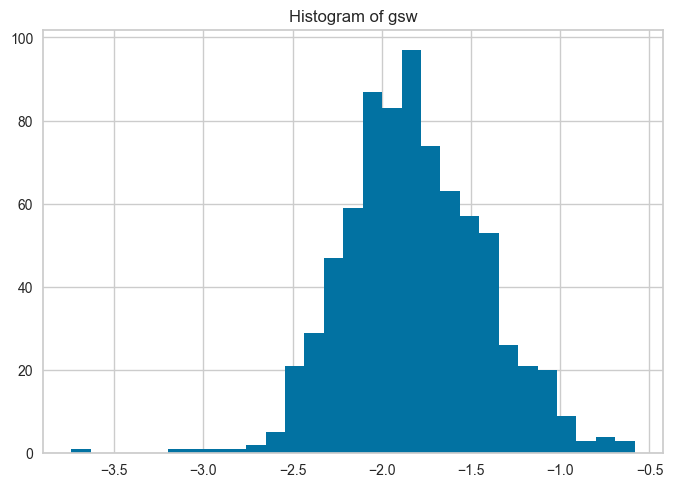

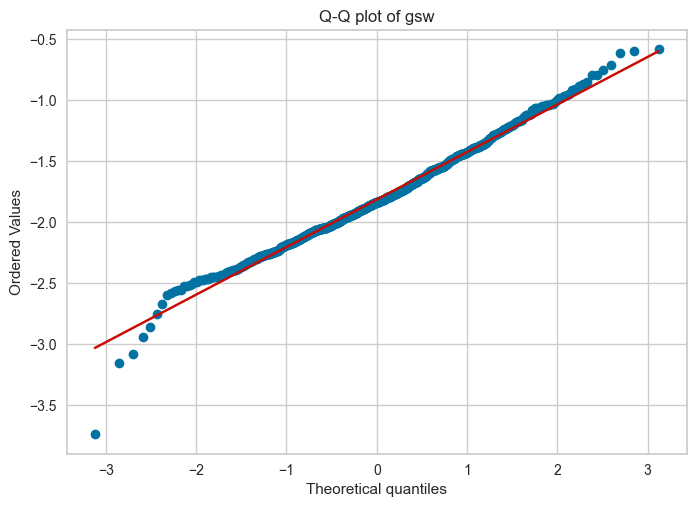

In [26]:
# Plot a histogram
plt.hist(df[data.target.name], bins='auto')
plt.title(f'Histogram of {data.target.name}')
plt.show()

# Plot a Q-Q plot
stats.probplot(df[data.target.name], plot=plt)
plt.title(f"Q-Q plot of {data.target.name}")
plt.show()


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     gsw      
No. Observations:     768         Method:                 REML     
No. Groups:           48          Scale:                  0.0772   
Min. group size:      16          Log-Likelihood:         -188.1861
Max. group size:      16          Converged:              Yes      
Mean group size:      16.0                                         
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               -1.829    0.047 -38.651 0.000 -1.922 -1.736
treatments[T.konv]       0.116    0.020   5.775 0.000  0.076  0.155
varieties[T.Carolus]    -0.048    0.040  -1.202 0.229 -0.127  0.030
varieties[T.KIS_Blegos] -0.115    0.040  -2.877 0.004 -0.194 -0.037
varieties[T.KIS_Kokra]  -0.015    0.040  -0.364 0.716 -0.093  0

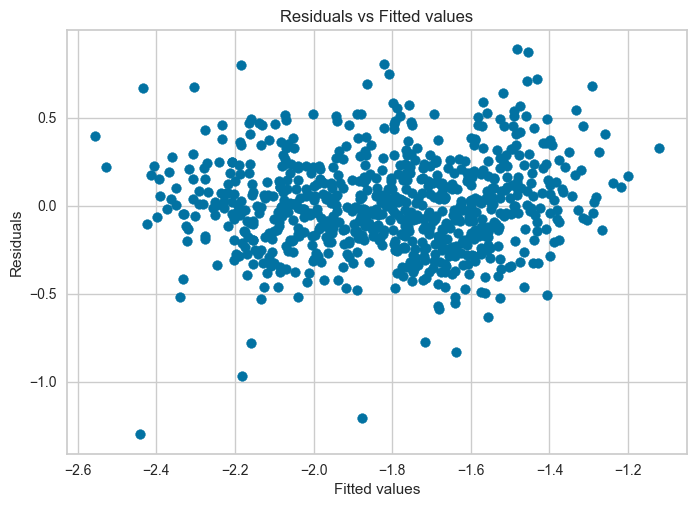

In [27]:
# Define the groups for the random effects
df["grouping"] = (
    df["blocks"].astype(str)
    + "_"
    + df["plants"].astype(str)
    + "_"
    + df["dates"].astype(str)
    # + "_"
    # + df["treatments"].astype(str)
    # + "_"
    # + df["varieties"].astype(str)
)

# Define the formula for the model
formula = f'{data.target.name} ~ treatments + varieties'

# Create the mixed linear model
model = smf.mixedlm(formula, df, groups=df['grouping'])

# Fit the model
result = model.fit(reml=True)

# Print the summary
print(result.summary())
# Print the AIC, BIC, log-likelihood, and deviance
print('AIC:', result.aic)
print('BIC:', result.bic)
print('Log-Likelihood:', result.llf)

# Plot the residuals
plt.scatter(result.fittedvalues, result.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()